# Préparation des données

In [5]:
import warnings

warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 4)
import matplotlib.pyplot as plt
import seaborn as sns

color_pal = sns.color_palette("husl", 9)
plt.style.use("fivethirtyeight")
from datetime import datetime, date
import math
import os
import re


In [15]:
import missingno as msno



Nous allons télécharger et préparer les données de consommation électrique des ménages

In [16]:
def prepare_power_consumption_data(csv_file_path: str) -> pd.DataFrame:
    """
    Preprocess the household power consumption data.

    Args:
        csv_file_path (str): The path to the CSV file containing the power consumption data.

    Returns:
        pd.DataFrame: The preprocessed power consumption data, resampled daily.
    """
    
    consumptions = pd.read_csv(
        csv_file_path,
        sep=";",
        header=0,
        na_values="?",
        dtype={"Date": str, "Time": str, "Global_active_power": np.float64},
        infer_datetime_format=False,
    )

    consumptions.rename(
        columns={
            "Date": "date",
            "Time": "time",
            "Global_active_power": "total_consumption",
        },
        inplace=True,
    )

    consumptions.index = pd.to_datetime(
        consumptions.date + "-" + consumptions.time, format="%d/%m/%Y-%H:%M:%S"
    )

    consumptions.drop(columns=["date", "time"], inplace=True)

    consumptions_df = consumptions.resample("D").sum()

    return consumptions_df


consumptions_df = prepare_power_consumption_data(
    "../data/01_raw/household_power_consumption.zip"
)
consumptions_df.head(1)

,total_consumption,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0


## Analyse exploratoire des données

In [17]:
consumptions_df.columns

Index(['total_consumption', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')

In [18]:
print(consumptions_df.shape)
consumptions_df.info()

(1442, 7)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1442 entries, 2006-12-16 to 2010-11-26
Freq: D
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   total_consumption      1442 non-null   float64
 1   Global_reactive_power  1442 non-null   float64
 2   Voltage                1442 non-null   float64
 3   Global_intensity       1442 non-null   float64
 4   Sub_metering_1         1442 non-null   float64
 5   Sub_metering_2         1442 non-null   float64
 6   Sub_metering_3         1442 non-null   float64
dtypes: float64(7)
memory usage: 90.1 KB


#### Visualisation de la consommation électrique 


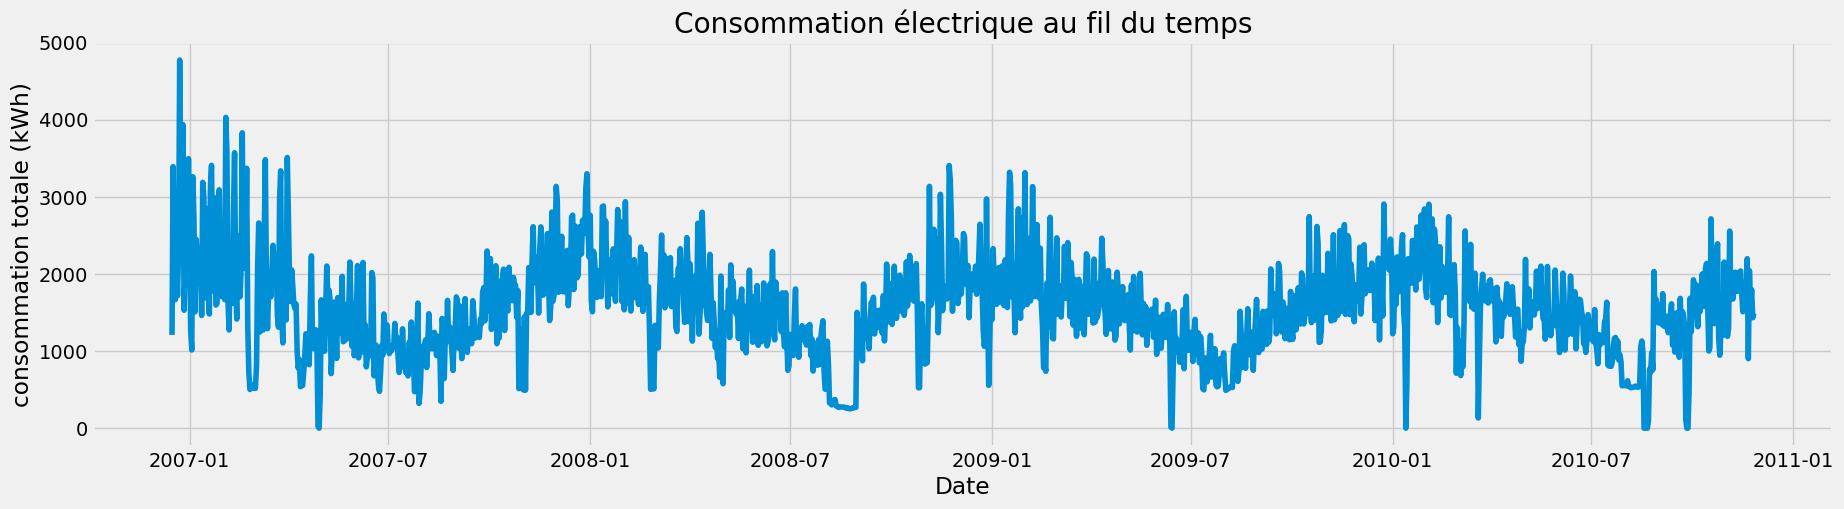

In [44]:
plt.figure(figsize=(20, 5))
plt.title("Consommation électrique au fil du temps")
plt.xlabel("Date")
plt.ylabel("consommation totale (kWh)")
plt.plot(consumptions_df["total_consumption"])
plt.show()

Le graphique révèle une saisonnalité marquée avec un schéma qui se répète chaque année, ce qui suggère l’intéret d’exploiter les variables temporelles. La tendance générale reste stable, avec une moyenne constante sur les années. quelques pics anormaux mériteraient d’être examinés.

#### Visualisation des tendances de la consommation electrique 

In [ ]:
# la métrique Rho
def calculate_rho(grouped_data, overall_mean):
    sum_of_squares_within = sum(
        grouped_data.apply(lambda x: len(x) * (x.mean() - overall_mean) ** 2)
    )
    total_sum_of_squares = sum(
        (consumptions_df_copy["total_consumption"] - overall_mean) ** 2
    )
    rho = sum_of_squares_within / total_sum_of_squares
    return rho



In [21]:
consumptions_df_copy = consumptions_df.copy()

In [ ]:
consumptions_df_copy["dayofweek"] = consumptions_df_copy.index.dayofweek
consumptions_df_copy["month"] = consumptions_df_copy.index.month
consumptions_df_copy["quarter"] = consumptions_df_copy.index.quarter
consumptions_df_copy["year"] = consumptions_df_copy.index.year
overall_mean = consumptions_df_copy["total_consumption"].mean()


In [23]:
# Categories
categories = ["dayofweek", "month", "quarter", "year"]
category_labels = [
    ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"],
    [
        "Jan",
        "Feb",
        "Mar",
        "Apr",
        "May",
        "Jun",
        "Jul",
        "Aug",
        "Sep",
        "Oct",
        "Nov",
        "Dec",
    ],
    ["Q1", "Q2", "Q3", "Q4"],
    range(consumptions_df_copy["year"].min(), consumptions_df_copy["year"].max() + 1),
]

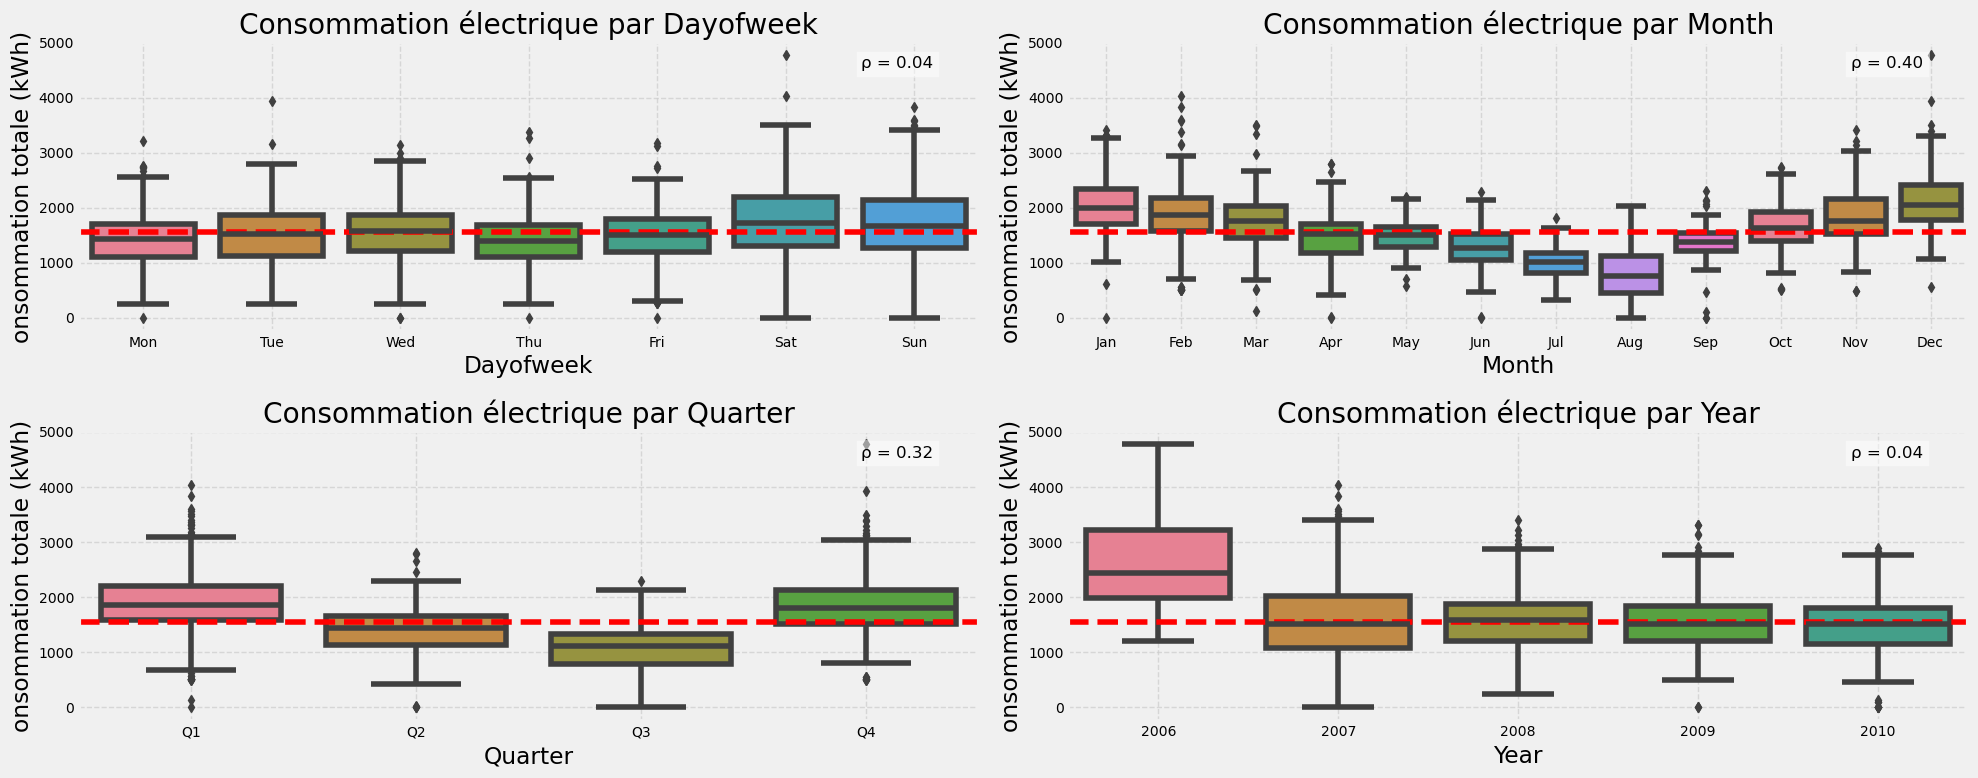

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(20, 8))

for i, (category, labels) in enumerate(zip(categories, category_labels)):
    ax = axes[i // 2, i % 2]
    sns.boxplot(
        data=consumptions_df_copy,
        x=category,
        y="total_consumption",
        ax=ax,
        palette=color_pal,
    )
    ax.grid(True, linestyle="--", alpha=0.7)

    
    grouped = consumptions_df_copy.groupby(category)["total_consumption"]
    rho = calculate_rho(grouped, overall_mean)

    
    ax.text(
        0.95,
        0.95,
        f"ρ = {rho:.2f}",
        transform=ax.transAxes,
        horizontalalignment="right",
        verticalalignment="top",
        fontsize=12,
        bbox=dict(facecolor="white", alpha=0.5),
    )

    ax.axhline(overall_mean, color="red", linestyle="--")

    ax.set_title(f"Consommation électrique par {category.capitalize()}")
    ax.set_xlabel(category.capitalize())
    ax.set_ylabel("onsommation totale (kWh)")
    ax.set_xticklabels(labels)
    ax.tick_params(axis="both", which="major", labelsize=10)

plt.tight_layout()
plt.show()


- **Tendances saisonnières** : Une hausse marquée de la consommation en été (juin à août), avec un coefficient de corrélation modéré (ρ = 0,40) pendant cette période. 
- **Schéma hebdomadaire** : Très peu de variation selon les jours de la semaine (ρ = 0,04), ce qui indique que cette variable est probablement peu prédictive.  
- **Stabilité annuelle** : La consommation reste stable d’une année à l’autre (ρ = 0,04), suggérant que l’année n’apporte pas beaucoup d’information au modèle.  
- **Influence trimestrielle** : Une hausse nette de la consommation au 3ᵉ trimestre, en lien avec la tendance saisonnière.


#### Analyse de la corrélation linéaire entre Target et les caractéristiques

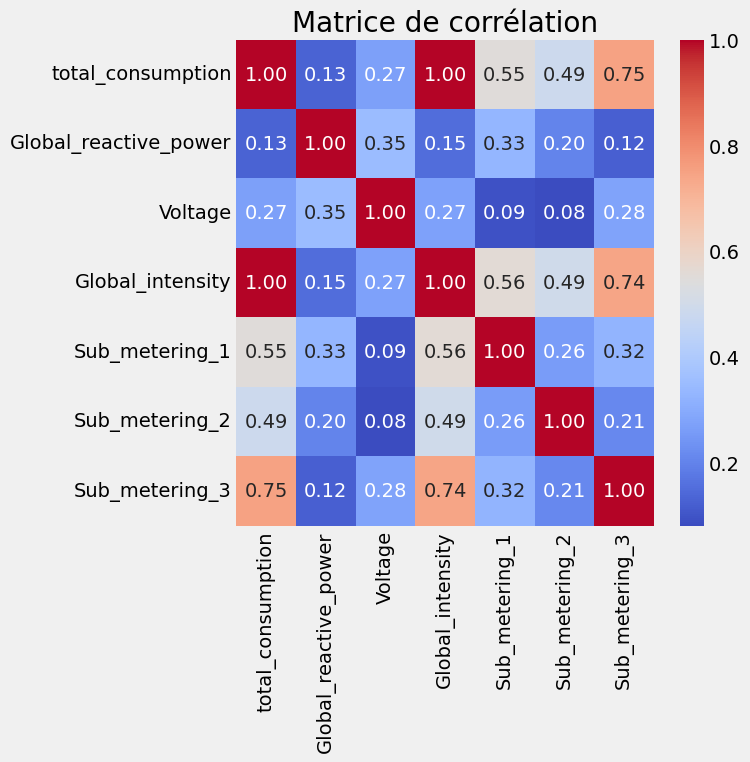

caractéristiques les plus corrélées avec 'total_consumption':
Global_intensity    0.999222
Sub_metering_3      0.751204
Sub_metering_1      0.549166
Name: total_consumption, dtype: float64


In [46]:
correlation_matrix = consumptions_df.corr()
plt.figure(figsize=(6, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matrice de corrélation")
plt.show()

threshold = 0.5
target_correlations = (
    correlation_matrix["total_consumption"].drop("total_consumption", axis=0).abs()
)

highly_correlated_features = target_correlations[target_correlations > threshold]
print("caractéristiques les plus corrélées avec 'total_consumption':")
print(highly_correlated_features.sort_values(ascending=False))

- *Global_intensity* est clairement le meilleur indicateur de la consommation, avec une corrélation quasi parfaite.  
- *Sub_metering_3* et *Sub_metering_1* jouent aussi un rôle, mais dans une moindre mesure.  
- Les autres variables ont peu d’influence sur la consommation totale.

### Récapitulatifs.

- **Période** : Les données sont entre  **16 décembre 2006** au **26 novembre 2010**.   
- **Qualité des données** : Aucune valeur manquante détectée.  
- **Variables prédictives** :  
  - **Global_reactive_power** (corrélation faible)  
  - **Voltage** (corrélation faible)  
  - **Global_intensity** (très forte corrélation, r = 0,999)  
  - **Sub_metering_1** (corrélation modérée)  
  - **Sub_metering_2** (corrélation faible)  
  - **Sub_metering_3** (forte corrélation, r = 0,75)  
  - **Date** est utilisée comme index du DataFrame et peut être exploitée pour l’analyse des tendances saisonnières.
  - **Variable cible** :  
  - La **consommation totale** est la variable cible.  



###  Traitement des Données meteo et jours fériées francais 
Nous utiliserons des données météorologiques, car la météo influence la consommation d’énergie. Nous prendrons également en compte les jours fériés en France , qui peuvent avoir un effet sur la consommation électrique.

On va nettoyer ces données et sélectionner les variables susceptibles d’améliorer les performances du modèle ML

In [26]:
french_holidays_df = pd.read_csv(
    "../data/01_raw/french_holidays.csv", parse_dates=["date"]
)
french_holidays_df.head(3)

,date,annee,zone,nom_jour_ferie
0,2004-01-01,2004,Métropole,1er janvier
1,2004-04-12,2004,Métropole,Lundi de Pâques
2,2004-05-01,2004,Métropole,1er mai


In [27]:
start_date = french_holidays_df.date.min()
end_date = french_holidays_df.date.max()

print(f"Data  from {str(start_date)[:10]} to {str(end_date)[:10]}")

Data  from 2004-01-01 to 2029-12-25


In [ ]:
weather_data_part1 = pd.read_csv(
    "../data/01_raw/weather_data_part1.csv",
    parse_dates=["datetime", "sunrise", "sunset"],
    index_col="datetime",
)

weather_data_part2 = pd.read_csv(
    "../data/01_raw/weather_data_part2.csv",
    parse_dates=["datetime", "sunrise", "sunset"],
    index_col="datetime",
)

weather_df = pd.concat([weather_data_part1, weather_data_part2], axis=0)

weather_df.tail(1)

,name,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,precipcover,preciptype,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-31,Sceaux,-1.1,-4.2,-3.0,-3.2,-8.9,-6.7,-5.1,85.8,0.0,0,0.0,NaN,0.0,0.0,22.4,12.4,6.6,1024.9,70.7,3.0,79.2,6.8,3.0,NaN,2011-01-31 08:22:43,2011-01-31 17:46:23,0.91,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"07149099999,07156099999,07146099999,0714509999..."


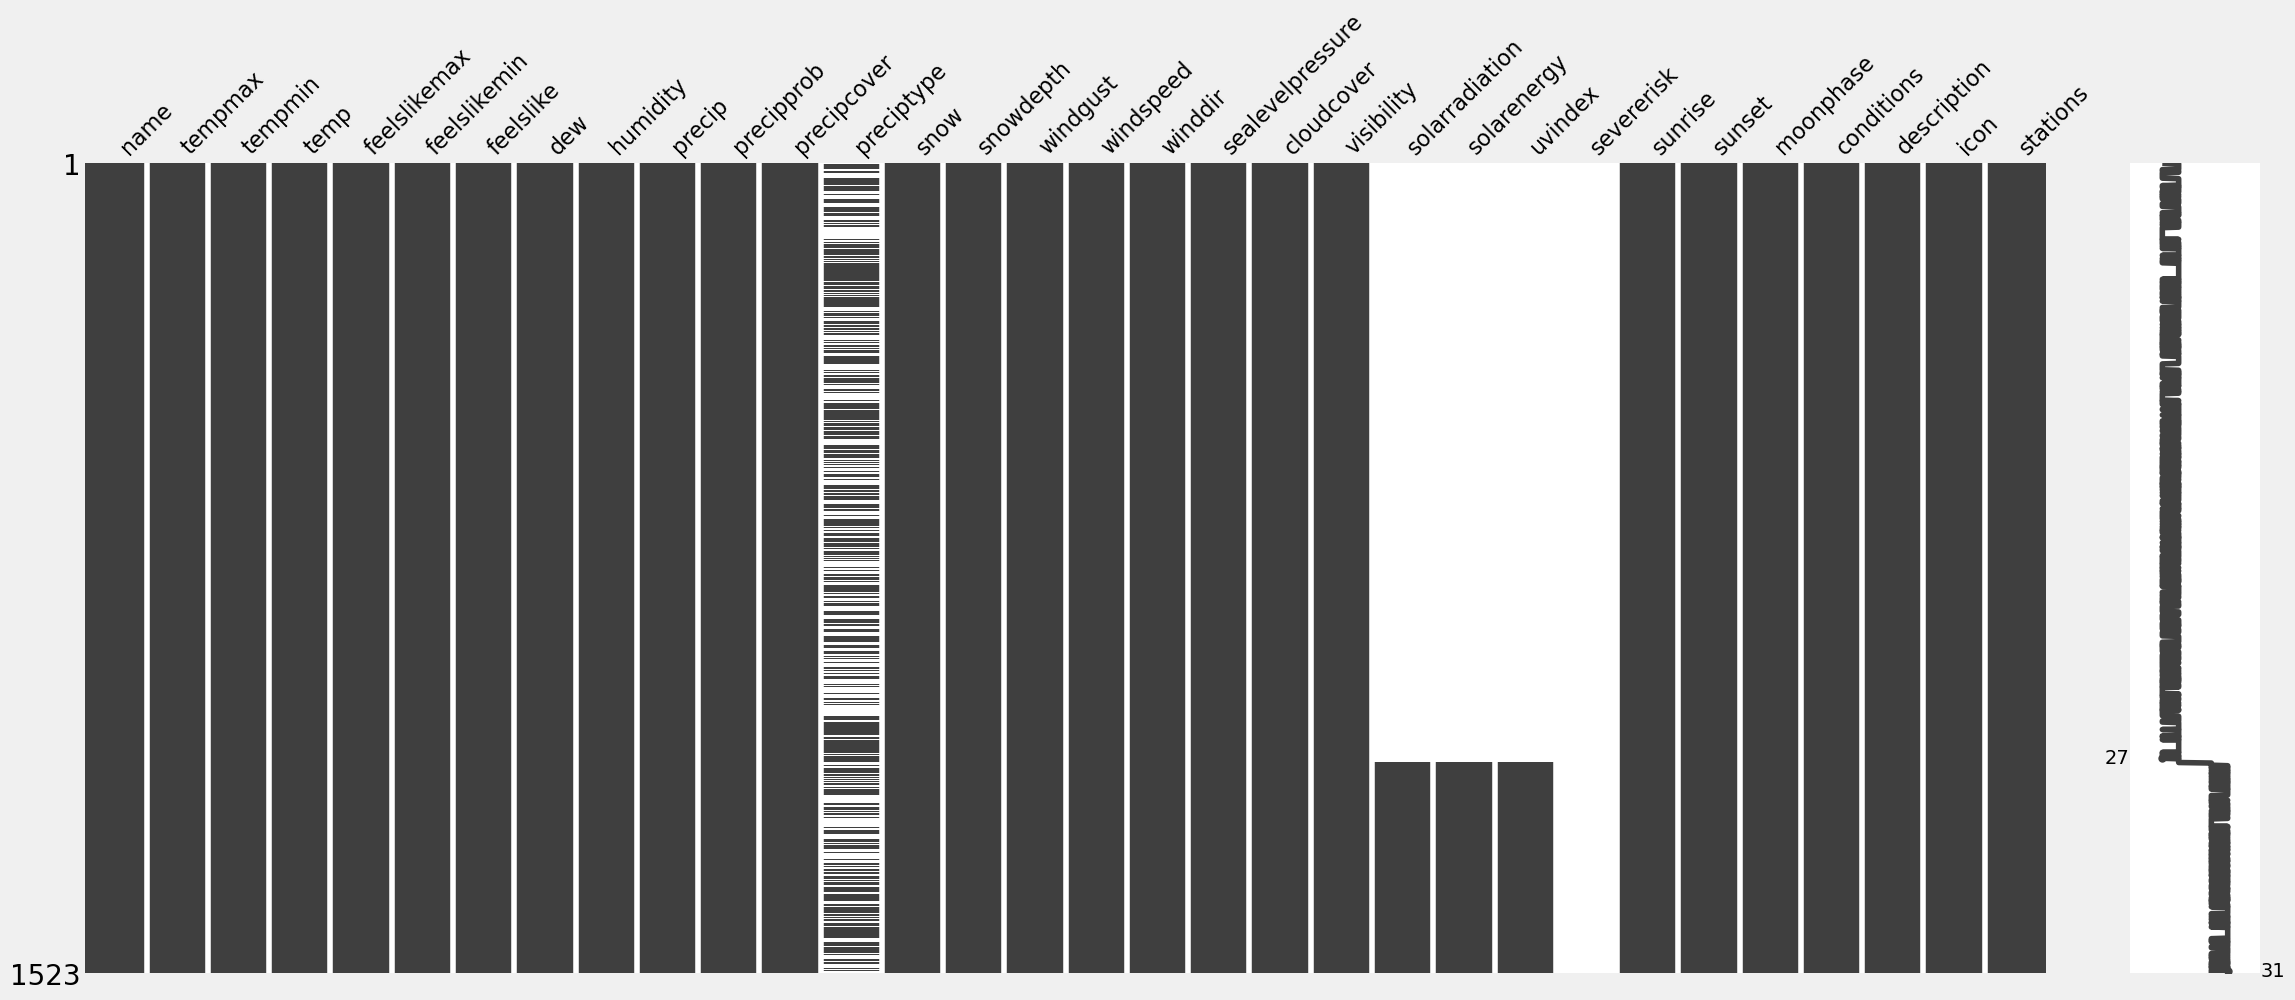

<Figure size 500x300 with 0 Axes>

In [ ]:
msno.matrix(weather_df)
plt.figure(figsize=(5, 3))
plt.show()

Le graphique montre que certaines colonnes du jeu de données météo contiennent des valeurs manquantes. Cela permettra d’orienter les choix de nettoyage, comme l’imputation ou la suppression de certaines variables.

In [30]:
def clean_string(s):
    """
    Cleans a string: replaces spaces with underscores, removes special characters, and converts to lowercase.
    """
    return re.sub(r"[^a-zA-Z0-9\s]", "", s.replace(" ", "_")).lower()


In [31]:
def calculate_day_length(df, sunrise_col="sunrise", sunset_col="sunset"):
    """
    Adds 'day_length' to df calculated from 'sunrise' and 'sunset', and drops these columns.
    """
    df[sunrise_col] = pd.to_datetime(df[sunrise_col], format="%H:%M:%S").dt.time
    df[sunset_col] = pd.to_datetime(df[sunset_col], format="%H:%M:%S").dt.time
    df["day_length"] = (
        (
            pd.to_datetime(df[sunset_col].astype(str))
            - pd.to_datetime(df[sunrise_col].astype(str))
        ).dt.total_seconds()
    ) / 3600.0
    return df.drop([sunrise_col, sunset_col], axis=1)

**Encoder 'Conditions'** : Nettoyer et appliquer un encodage One-Hot à la colonne *conditions*
**Calculer  Day Length** : Utiliser les colonnes *Sunrise* et *Sunset* pour créer une variable *Durée du jour*

In [ ]:
def preprocess_weather_data(
    df, start_date, end_date, columns_to_keep, column_to_encode
):
    """
    Preprocesses weather data: sorts by index, filters by date, selects columns, encodes a column, and calculates day length.
    """
    df.sort_index(inplace=True)
    df_selected = df[columns_to_keep].copy()
    df_filtered = df_selected[
        (df_selected.index >= start_date) & (df_selected.index <= end_date)
    ].copy()


    df_filtered[column_to_encode] = df_filtered[column_to_encode].apply(clean_string)
    dummies = pd.get_dummies(df_filtered[column_to_encode], prefix=column_to_encode)
    df_encoded = pd.concat([df_filtered, dummies], axis=1).drop(
        column_to_encode, axis=1
    )

    return calculate_day_length(df_encoded)

In [ ]:
columns_to_keep = [
    "tempmax",
    "tempmin",
    "temp",
    "feelslikemax",
    "feelslikemin",
    "feelslike",
    "dew",
    "humidity",
    "precip",
    "precipprob",
    "precipcover",
    "snow",
    "snowdepth",
    "windgust",
    "windspeed",
    "winddir",
    "sealevelpressure",
    "cloudcover",
    "visibility",
    "sunrise",
    "sunset",
    "moonphase",
    "conditions",
]

column_to_encode = "conditions"
start_date = "2006-12-16"
end_date = "2010-11-26"



In [ ]:
processed_weather_df = preprocess_weather_data(
    df=weather_df,
    start_date=start_date,
    end_date=end_date,
    columns_to_keep=columns_to_keep,
    column_to_encode=column_to_encode,
)

processed_weather_df.head(1)

,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,moonphase,conditions_clear,conditions_overcast,conditions_partiallycloudy,conditions_rain,conditions_rainovercast,conditions_rainpartiallycloudy,conditions_snowovercast,conditions_snowpartiallycloudy,conditions_snowrain,conditions_snowrainovercast,conditions_snowrainpartiallycloudy,day_length
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2006-12-16,8.2,3.4,5.7,5.7,0.6,2.9,4.1,89.8,1.853,100,29.17,0.0,0.0,39.8,19.1,235.4,1023.2,68.6,10.2,0.87,False,False,False,False,False,True,False,False,False,False,False,8.278889


#### Joindre les DataFrames

In [38]:
weather_and_consumption_df = pd.merge(
    consumptions_df, processed_weather_df, left_index=True, right_index=True
)
weather_and_consumption_df.head(1)

,total_consumption,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,moonphase,conditions_clear,conditions_overcast,conditions_partiallycloudy,conditions_rain,conditions_rainovercast,conditions_rainpartiallycloudy,conditions_snowovercast,conditions_snowpartiallycloudy,conditions_snowrain,conditions_snowrainovercast,conditions_snowrainpartiallycloudy,day_length
2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0,8.2,3.4,5.7,5.7,0.6,2.9,4.1,89.8,1.853,100,29.17,0.0,0.0,39.8,19.1,235.4,1023.2,68.6,10.2,0.87,False,False,False,False,False,True,False,False,False,False,False,8.278889


##### Jours fériés

In [47]:
french_holidays_set = set(french_holidays_df.date)
weather_and_consumption_df["is_holiday"] = weather_and_consumption_df.index.isin(
    french_holidays_set
)
weather_and_consumption_df.head(1)

,total_consumption,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,moonphase,conditions_clear,conditions_overcast,conditions_partiallycloudy,conditions_rain,conditions_rainovercast,conditions_rainpartiallycloudy,conditions_snowovercast,conditions_snowpartiallycloudy,conditions_snowrain,conditions_snowrainovercast,conditions_snowrainpartiallycloudy,day_length,is_holiday
2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0,8.2,3.4,5.7,5.7,0.6,2.9,4.1,89.8,1.853,100,29.17,0.0,0.0,39.8,19.1,235.4,1023.2,68.6,10.2,0.87,False,False,False,False,False,True,False,False,False,False,False,8.278889,False


### Corrélation  entre target et les variables explicatives aprés features engineering 

In [48]:
correlation_matrix = weather_and_consumption_df.corr()
threshold = 0.5
highly_correlated_features = (
    correlation_matrix["total_consumption"].drop("total_consumption").abs()
)
highly_correlated_features = highly_correlated_features[
    highly_correlated_features > threshold
].sort_values(ascending=False)

print("Variables les plus corrélées avec 'total_consumption':")
for feature in highly_correlated_features.index:
    print(" " + feature)

Variables les plus corrélées avec 'total_consumption':
 Global_intensity
 Sub_metering_3
 Sub_metering_1
 temp
 day_length
 tempmax
 feelslike
 feelslikemax
 feelslikemin
 tempmin


In [41]:
weather_and_consumption_df.head(1)

,total_consumption,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,moonphase,conditions_clear,conditions_overcast,conditions_partiallycloudy,conditions_rain,conditions_rainovercast,conditions_rainpartiallycloudy,conditions_snowovercast,conditions_snowpartiallycloudy,conditions_snowrain,conditions_snowrainovercast,conditions_snowrainpartiallycloudy,day_length,is_holiday
2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0,8.2,3.4,5.7,5.7,0.6,2.9,4.1,89.8,1.853,100,29.17,0.0,0.0,39.8,19.1,235.4,1023.2,68.6,10.2,0.87,False,False,False,False,False,True,False,False,False,False,False,8.278889,False


In [42]:
weather_and_consumption_df.to_csv(
    "../data/02_processed/processed_weather_and_consumption_data.csv", index=True
)